# Study Sequences as Markov Chains

*Xiaolin Zhuo*

I analyze heterogeneity in how Wikipedia users respond to toxic comments on talk pages. I construct sequences of actions users take against toxic comments and their matching nontoxic comments (to compare across the two groups). Here I explore modeling the data generating process of the response sequences as a Markov chain. 

The sequences are made up of five possible actions: reply, modify, remove, archive, restore, and leave (no action). 

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tqdm
import warnings
import seaborn as sns
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta
from scipy import stats
from matplotlib import rcParams

warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
# read data - 'focal comments' that trigger response sequences
comments = pd.read_csv('../data/bio_matches.csv', parse_dates=['timestamp'])
print(comments.shape)
comments.sort_values('match_id').head(6)

(1496, 52)


,ancestor_id,author_anon,author_editcount_talk,author_edits_wiki,author_tenure,authors,cleaned_content,content,conversation_id,file_number,...,toxic_content95,toxic_new,toxic_new85,toxic_new95,toxicity,type,user_id,user_text,weekend,year
313,420483313.86771.86730,True,0.0,0.0,0.0,ANONYMOUS:182.54.162.171,I can't do it from this computer. Paglia's pag...,I can't do it from this computer. Paglia's pag...,420483313.86730.86730,10056,...,False,False,False,False,0.237576,ADDITION,0.0,182.54.162.171,0,2011
312,271834000.26509.26509,True,0.0,0.0,0.0,ANONYMOUS:160.253.0.8,"It's pronounced ""Ass.""","It's pronounced ""Ass.""\n",271125940.25761.25761,10056,...,False,True,True,False,0.904057,ADDITION,0.0,160.253.0.8,0,2009
18,219337244.35118.35086,False,0.0,0.0,0.0,856871:Boomshadow,The bio here gives the start date of Christie'...,The bio here gives the start date of Christie'...,219337244.35086.35086,1038,...,False,False,False,False,0.073367,ADDITION,856871.0,Boomshadow,0,2008
16,226339968.36310.36253,False,0.0,0.0,0.0,6229030:JasonHockeyGuy,What does Sexy Bitch have to do with this book...,What does Sexy Bitch have to do with this book...,226339968.36253.36253,1038,...,False,True,True,False,0.918037,ADDITION,6229030.0,JasonHockeyGuy,0,2008
19,120477336.20039.20029,True,0.0,0.0,0.0,ANONYMOUS:74.101.74.85,"""Agatha Christie died on 12 January 1976, at a...","""Agatha Christie died on 12 January 1976, at a...",120477336.20029.20029,1038,...,False,False,False,False,0.219932,ADDITION,0.0,74.101.74.85,0,2007
17,115539272.20042.20042,True,0.0,0.0,0.0,ANONYMOUS:212.239.214.245,she was fucking loser,she was fucking loser\n,93913380.18821.18821,1038,...,True,True,True,True,0.966640,ADDITION,0.0,212.239.214.245,0,2007


In [3]:
# responses to 'focal comments'
responses = pd.read_csv('../data/responses_bio_full_type2.csv', parse_dates=['timestamp'])
responses = responses.sort_values(['comment_id', 'timestamp', 'rev_id', 'type_num'])
responses.head()

,ancestor_id,authors,cleaned_content,comment_id,content,conversation_id,file_number,id,indentation,isUnchanged,...,toxic_new85,toxic_new95,toxicity,type,type_dup,type_num,user_id,user_text,user_text_comment,type2
0,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,101074254.0.29103,1.0,True,...,False,False,0.077377,DELETION,DELETION,2.0,NaN,84.45.192.59,Bjewiki,REMOVE
1,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,112692328.31258.0,1.0,True,...,False,False,0.077377,RESTORATION,RESTORATION,0.0,1489448.0,Picus viridis,Bjewiki,RESTORE
2,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,114559472.0.31258,1.0,True,...,False,False,0.077377,DELETION,DELETION,2.0,NaN,169.199.116.32,Bjewiki,REMOVE
3,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,126665481.31888.0,1.0,True,...,False,False,0.077377,RESTORATION,RESTORATION,0.0,177507.0,I64s,Bjewiki,RESTORE
4,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,127378050.1002.31888,1.0,True,...,False,False,0.077377,DELETION,DELETION,2.0,990951.0,Lucy-marie,Bjewiki,ARCHIVE


In [4]:
# get bot list
with open('../data/bots.txt', 'r') as f:
    bots = f.readlines()
bots = [b.strip('\n') for b in bots]
print(bots[:5])

['Lowercase sigmabot', 'Lowercase sigmabot I', 'Lowercase sigmabot II', 'Lowercase sigmabot III', 'Lowercase sigmabot V']


## Response times in total and between turns

### Prepare data for plotting

In [5]:
# remove comments that lack responses
r_subset = responses[responses.type.notnull()]
r_subset = r_subset.drop_duplicates(['type', 'timestamp', 'comment_id', 'rev_id']) # remove duplicates
c_subset = comments[comments.id.isin(r_subset.comment_id.values)]

# append comments and responses to calcualte time gaps
comments_responses = c_subset[['id', 'timestamp', 'toxic']]
comments_responses['comment_id'] = comments_responses.id
comments_responses = comments_responses.drop_duplicates().append(r_subset[['comment_id', 'id', 'timestamp', 'toxic', 'step', 'type']])
comments_responses = comments_responses.sort_values(['comment_id', 'timestamp'])
comments_responses

,comment_id,id,step,timestamp,toxic,type
287,100681768.29103.29103,100681768.29103.29103,NaN,2007-01-14 17:03:47+00:00,False,NaN
0,100681768.29103.29103,101074254.0.29103,0.0,2007-01-16 10:54:08+00:00,False,DELETION
1,100681768.29103.29103,112692328.31258.0,1.0,2007-03-05 00:41:34+00:00,False,RESTORATION
2,100681768.29103.29103,114559472.0.31258,2.0,2007-03-12 15:34:51+00:00,False,DELETION
3,100681768.29103.29103,126665481.31888.0,3.0,2007-04-28 17:40:00+00:00,False,RESTORATION
...,...,...,...,...,...,...
257,99359630.27109.27109,99359630.27109.27109,NaN,2007-01-08 17:47:30+00:00,True,NaN
2253,99359630.27109.27109,99359835.27109.27109,0.0,2007-01-08 17:48:34+00:00,True,DELETION
1167,99501162.2860.2835,99501162.2860.2835,NaN,2007-01-09 05:33:38+00:00,False,NaN
2254,99501162.2860.2835,172489186.4556.4556,0.0,2007-11-19 14:41:45+00:00,False,ADDITION


In [6]:
# calculate time differences between turns 
comments_responses['timegap'] = comments_responses.groupby('comment_id').timestamp.diff()

# then take out 'focal comments'
comments_responses = comments_responses[comments_responses.step.notnull()]

In [7]:
# for example: time delta object, gap in seconds, gap in days
comments_responses.iloc[1]['timegap'], comments_responses.iloc[1]['timegap'].seconds, \
comments_responses.iloc[1]['timegap'].days

(Timedelta('47 days 13:47:26'), 49646, 47)

In [8]:
# create new variable of counting response days
comments_responses['within_days'] = comments_responses.timegap.map(lambda t: t.days+1)
comments_responses.head()

,comment_id,id,step,timestamp,toxic,type,timegap,within_days
0,100681768.29103.29103,101074254.0.29103,0.0,2007-01-16 10:54:08+00:00,False,DELETION,1 days 17:50:21,2
1,100681768.29103.29103,112692328.31258.0,1.0,2007-03-05 00:41:34+00:00,False,RESTORATION,47 days 13:47:26,48
2,100681768.29103.29103,114559472.0.31258,2.0,2007-03-12 15:34:51+00:00,False,DELETION,7 days 14:53:17,8
3,100681768.29103.29103,126665481.31888.0,3.0,2007-04-28 17:40:00+00:00,False,RESTORATION,47 days 02:05:09,48
4,100681768.29103.29103,127378050.1002.31888,4.0,2007-05-01 09:25:03+00:00,False,DELETION,2 days 15:45:03,3


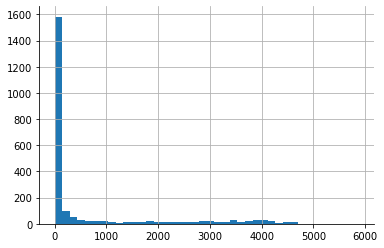

In [9]:
comments_responses.within_days.hist(bins=40)
remove_border()

In [10]:
# number of turns per sequence
summary = comments_responses.groupby('comment_id').timestamp.count().reset_index()
summary.columns = ['comment_id', 'length']
summary.length.value_counts()

1     1040
2      215
3       90
4       44
5       26
6        8
9        5
8        5
7        5
10       3
Name: length, dtype: int64

In [12]:
# get total days that a sequence lasts
tmp = comments_responses.groupby('comment_id').timegap.sum().reset_index()
tmp.columns = ['comment_id', 'total_days']
tmp.total_days = tmp.total_days.map(lambda t: t.days+1)
summary = summary.merge(tmp, on='comment_id', how='left')

In [13]:
summary.head()

,comment_id,length,total_days
0,100681768.29103.29103,5,107
1,101024247.60.60,1,4184
2,101270350.44580.44562,1,9
3,102511390.4360.4360,1,4178
4,103113249.1309.1309,4,73


### Plot total days of response by sequence length

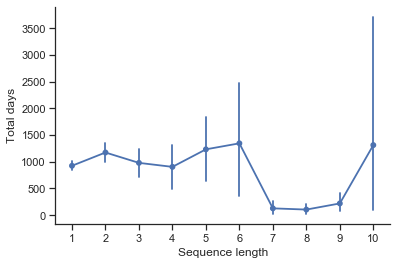

In [14]:
sns.set(style="ticks", rc={"lines.linewidth": 1}) # style
g = sns.pointplot(x="length", y="total_days", data=summary)
plt.xlabel('Sequence length')
plt.ylabel('Total days')
remove_border(g)
# plt.savefig('../plots/totaldays_by_seqlen.pdf', bbox_inches='tight')

### Add average days between turns by sequence length to the above plot

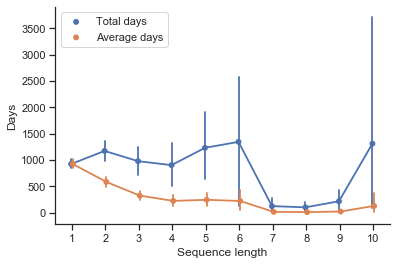

In [15]:
tmp = comments_responses.groupby('comment_id').within_days.mean().reset_index()
tmp.columns = ['comment_id', 'avg_days']
summary = summary.merge(tmp, on='comment_id')

reformatted = summary[['length', 'total_days']]
reformatted.columns = ['length', 'y']
reformatted['kind'] = 'Total days'

tmp = summary[['length', 'avg_days']]
tmp.columns = ['length', 'y']
reformatted = reformatted.append(tmp)
reformatted = reformatted.fillna('Average days')

g = sns.pointplot(x="length", y="y", hue='kind', dodge=True, data=reformatted)
g.legend(title=None)
plt.xlabel('Sequence length')
plt.ylabel('Days')
remove_border(g)

Response sequences with more turns do not necessarily take longer time in total or at each turn on average. Sequences of length 7-9 are particularly 'quick.' 

## Sequence permutation

### Reformat sequences

In [16]:
# remove repeated actions
responses = responses.drop_duplicates(['type2', 'timestamp', 'comment_id', 'rev_id'])

In [17]:
# confirm each sequence ends in an absorbing state 'LEAVE'
all(responses.groupby('comment_id').last().type == 'LEAVE')

False

In [19]:
# add an absorbing state at end of each sequence

# find sequences that did not end with 'LEAVE'
tmp = responses.groupby('comment_id').last().type2 == 'LEAVE'
leave_rows = pd.DataFrame(tmp.index[tmp==False])
leave_rows['type2'] = 'LEAVE'

# use data collection time as timestamp
utc = responses.iloc[0]['timestamp'].tz # get time zone
endtime = datetime(2018, 7, 1, 0, 0, tzinfo=utc)
leave_rows['timestamp'] = endtime
leave_rows.head()

,comment_id,type2,timestamp
0,100681768.29103.29103,LEAVE,2018-07-01 00:00:00+00:00
1,101270350.44580.44562,LEAVE,2018-07-01 00:00:00+00:00
2,103113249.1309.1309,LEAVE,2018-07-01 00:00:00+00:00
3,103834037.78685.78685,LEAVE,2018-07-01 00:00:00+00:00
4,104622115.32146.32146,LEAVE,2018-07-01 00:00:00+00:00


In [20]:
# set sorting order in case I need to sort multiple types in a single revision
type_to_number = {'ADDITION':1, 'MODIFICATION':1, 'CREATION':0, 
                  'RESTORATION':0, 'DELETION': 2}
responses['type_num'] = responses.type.map(lambda t: type_to_number.get(t))

In [21]:
responses = responses.append(leave_rows)
responses = responses.sort_values(['comment_id', 'timestamp', 'rev_id', 'type_num'])

In [22]:
# prepare data for reshaping
# I want 11 turns per sequence. Add empty rows to a response sequence if fewer than 11 turns

def edit_df(df):
    df = df.reset_index(drop=True).reindex(np.arange(11))
    df.step = np.arange(11)
    df = df.reset_index(drop=True)
    df.step = df.index
    df.comment_id = df.iloc[0]['comment_id']
    return df

responses = responses.groupby('comment_id').apply(edit_df).reset_index(drop=True)
responses.head(10)

,ancestor_id,authors,cleaned_content,comment_id,content,conversation_id,file_number,id,indentation,isUnchanged,...,toxic_new85,toxic_new95,toxicity,type,type2,type_dup,type_num,user_id,user_text,user_text_comment
0,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,101074254.0.29103,1.0,True,...,False,False,0.077377,DELETION,REMOVE,DELETION,2.0,NaN,84.45.192.59,Bjewiki
1,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,112692328.31258.0,1.0,True,...,False,False,0.077377,RESTORATION,RESTORE,RESTORATION,0.0,1489448.0,Picus viridis,Bjewiki
2,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,114559472.0.31258,1.0,True,...,False,False,0.077377,DELETION,REMOVE,DELETION,2.0,NaN,169.199.116.32,Bjewiki
3,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,126665481.31888.0,1.0,True,...,False,False,0.077377,RESTORATION,RESTORE,RESTORATION,0.0,177507.0,I64s,Bjewiki
4,100681768.29103.29103,1652663:Bjewiki,I agree. It might be different if there was s...,100681768.29103.29103,:I agree. It might be different if there was ...,100616974.28239.28239,8729.0,127378050.1002.31888,1.0,True,...,False,False,0.077377,DELETION,ARCHIVE,DELETION,2.0,990951.0,Lucy-marie,Bjewiki
5,NaN,NaN,NaN,100681768.29103.29103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,LEAVE,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,100681768.29103.29103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,100681768.29103.29103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,100681768.29103.29103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,100681768.29103.29103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# reformat sequences in long format
seq = responses.pivot(index='comment_id', columns='step', values='type2').reset_index(level='comment_id')
seq.head()

step,comment_id,0,1,2,3,4,5,6,7,8,9,10
0,100681768.29103.29103,REMOVE,RESTORE,REMOVE,RESTORE,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN
1,101024247.60.60,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101270350.44580.44562,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,102511390.4360.4360,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,103113249.1309.1309,MODIFY,REMOVE,RESTORE,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# check first row
responses[responses.comment_id==seq.iloc[0]['comment_id']].type2

0      REMOVE
1     RESTORE
2      REMOVE
3     RESTORE
4     ARCHIVE
5       LEAVE
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
Name: type2, dtype: object

In [27]:
# rename columns
new_cols = ['s%i'%col if col != 'comment_id' else col for col in seq.columns]
seq.columns = new_cols
seq

,comment_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,100681768.29103.29103,REMOVE,RESTORE,REMOVE,RESTORE,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN
1,101024247.60.60,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101270350.44580.44562,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,102511390.4360.4360,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,103113249.1309.1309,MODIFY,REMOVE,RESTORE,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1436,98527732.1147.1146,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,98635360.44807.44807,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1438,98975171.3433.3433,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1439,99359630.27109.27109,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sequence counts

In [28]:
# print seq in a string
seq['seq_str'] = seq.apply(lambda row: '-'.join([row['s%i'%i] for i in range(11) if pd.notnull(row['s%i'%i])]), axis=1)
seq.head()

,comment_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,seq_str
0,100681768.29103.29103,REMOVE,RESTORE,REMOVE,RESTORE,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,REMOVE-RESTORE-REMOVE-RESTORE-ARCHIVE-LEAVE
1,101024247.60.60,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEAVE
2,101270350.44580.44562,REMOVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REMOVE-LEAVE
3,102511390.4360.4360,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEAVE
4,103113249.1309.1309,MODIFY,REMOVE,RESTORE,ARCHIVE,LEAVE,NaN,NaN,NaN,NaN,NaN,NaN,MODIFY-REMOVE-RESTORE-ARCHIVE-LEAVE


In [29]:
# sequences of length 1
seq[seq.s1.isnull()].seq_str.value_counts()

LEAVE    280
Name: seq_str, dtype: int64

In [30]:
# sequences of length 2
seq[((seq.s2.isnull() & (seq.s1.notnull())))].seq_str.value_counts()

REMOVE-LEAVE     646
ARCHIVE-LEAVE    114
REPLY-LEAVE       32
MODIFY-LEAVE      31
Name: seq_str, dtype: int64

In [31]:
# sequences of length 3
seq[((seq.s3.isnull() & (seq.s2.notnull())))].seq_str.value_counts()

REPLY-ARCHIVE-LEAVE     49
MODIFY-ARCHIVE-LEAVE    42
MODIFY-REMOVE-LEAVE     35
REPLY-REMOVE-LEAVE      26
REPLY-REPLY-LEAVE       13
MODIFY-MODIFY-LEAVE      7
REPLY-MODIFY-LEAVE       2
REMOVE-RESTORE-LEAVE     1
Name: seq_str, dtype: int64

## Transition probability matrix 

### For all

In [32]:
states = responses.type2.unique().tolist()
states = [s for s in states if pd.notnull(s)]
states.sort()
states

['ARCHIVE', 'LEAVE', 'MODIFY', 'REMOVE', 'REPLY', 'RESTORE']

In [33]:
# manually order states for presentation 
states = ['REPLY', 'MODIFY', 'RESTORE', 'ARCHIVE', 'REMOVE', 'LEAVE']

In [34]:
# count pairs of consecutive actions

counts = defaultdict(int)

for i, row in seq[seq.s2.notnull()].iterrows():
    for i in range(10):
        if pd.notnull(row['s%i'%(i+1)]):
            counts[(row['s%i'%i], row['s%i'%(i+1)])] += 1

In [35]:
counts

defaultdict(int,
            {('REMOVE', 'RESTORE'): 134,
             ('RESTORE', 'REMOVE'): 91,
             ('RESTORE', 'ARCHIVE'): 30,
             ('ARCHIVE', 'LEAVE'): 168,
             ('MODIFY', 'REMOVE'): 65,
             ('MODIFY', 'MODIFY'): 87,
             ('REMOVE', 'LEAVE'): 127,
             ('REPLY', 'ARCHIVE'): 70,
             ('REPLY', 'REMOVE'): 55,
             ('MODIFY', 'ARCHIVE'): 69,
             ('RESTORE', 'LEAVE'): 9,
             ('REPLY', 'REPLY'): 77,
             ('REPLY', 'MODIFY'): 11,
             ('MODIFY', 'LEAVE'): 16,
             ('REPLY', 'LEAVE'): 18,
             ('RESTORE', 'REPLY'): 5,
             ('ARCHIVE', 'RESTORE'): 2,
             ('RESTORE', 'MODIFY'): 1})

In [36]:
# make an empty matrix
count_matrix = pd.DataFrame(columns=states, index=states)
count_matrix

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,NaN,NaN,NaN,NaN,NaN,NaN
MODIFY,NaN,NaN,NaN,NaN,NaN,NaN
RESTORE,NaN,NaN,NaN,NaN,NaN,NaN
ARCHIVE,NaN,NaN,NaN,NaN,NaN,NaN
REMOVE,NaN,NaN,NaN,NaN,NaN,NaN
LEAVE,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# fill in counts
for k, v in counts.items():
    count_matrix.loc[k[0], k[1]] = v
    
count_matrix

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,77,11,NaN,70,55,18
MODIFY,NaN,87,NaN,69,65,16
RESTORE,5,1,NaN,30,91,9
ARCHIVE,NaN,NaN,2,NaN,NaN,168
REMOVE,NaN,NaN,134,NaN,NaN,127
LEAVE,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# fill null with 0
count_matrix = count_matrix.fillna(0)

In [39]:
# make row sums to 1 - property of transition probability matrix
prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
prob_matrix

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,0.333333,0.047619,0.000000,0.303030,0.238095,0.077922
MODIFY,0.000000,0.367089,0.000000,0.291139,0.274262,0.067511
RESTORE,0.036765,0.007353,0.000000,0.220588,0.669118,0.066176
ARCHIVE,0.000000,0.000000,0.011765,0.000000,0.000000,0.988235
REMOVE,0.000000,0.000000,0.513410,0.000000,0.000000,0.486590
LEAVE,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# fix row for LEAVE
prob_matrix = prob_matrix.fillna(0)
prob_matrix.loc['LEAVE', 'LEAVE'] = 1
prob_matrix

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,0.333333,0.047619,0.000000,0.303030,0.238095,0.077922
MODIFY,0.000000,0.367089,0.000000,0.291139,0.274262,0.067511
RESTORE,0.036765,0.007353,0.000000,0.220588,0.669118,0.066176
ARCHIVE,0.000000,0.000000,0.011765,0.000000,0.000000,0.988235
REMOVE,0.000000,0.000000,0.513410,0.000000,0.000000,0.486590
LEAVE,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [41]:
# columns may not sum to 1
prob_matrix.sum(axis=0)

REPLY      0.370098
MODIFY     0.422061
RESTORE    0.525175
ARCHIVE    0.814758
REMOVE     1.181474
LEAVE      2.686434
dtype: float64

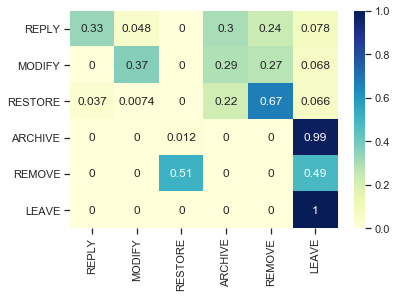

In [42]:
sns.heatmap(prob_matrix, cmap="YlGnBu", annot=True)

This probability transition matrix makes sense. Archive is often final and is followed by leave 99 percent of the time. Restore and remove follow one another frequently. Reply is likely to elicit one more reply, or archive, or remove. Modify is also likely to elicit one more modify, or archive, or remove. 

### <font color='tomato'>Calculate transition matrices by toxicity</font>

In [43]:
toxic_ids = comments[comments.toxic].id
seq_toxic = seq[seq.comment_id.isin(toxic_ids)]
seq_nontoxic = seq[~seq.comment_id.isin(toxic_ids)]

In [44]:
def get_transition_matrix(sequences):

    # pairs of consecutive actions
    nested_ls = sequences[sequences.s1.notnull()].apply(lambda row: [(row['s%i'%i], row['s%i'%(i+1)]) 
                                                         for i in range(10) if pd.notnull(row['s%i'%(i+1)])], axis=1).tolist()
    pairs = []
    for l in nested_ls:
        pairs += l
    print(len(pairs), 'pairs of consecutive actions')
    
    
    # make an empty matrix
    count_matrix = pd.DataFrame(columns=states, index=states)

    # fill matrix
    for p in set(pairs):
        count_matrix.loc[p[0], p[1]] = pairs.count(p)

    count_matrix = count_matrix.fillna(0)
    prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
    prob_matrix.loc['LEAVE', :] = [0] * 5 + [1]
    
    return prob_matrix

In [45]:
tr_matrix_toxic = get_transition_matrix(seq_toxic)
tr_matrix_nontoxic = get_transition_matrix(seq_nontoxic)

845 pairs of consecutive actions
1013 pairs of consecutive actions


In [46]:
tr_matrix_toxic

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,0.311688,0.038961,0.000000,0.259740,0.194805,0.194805
MODIFY,0.000000,0.345794,0.000000,0.186916,0.308411,0.158879
RESTORE,0.032258,0.032258,0.000000,0.161290,0.645161,0.129032
ARCHIVE,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
REMOVE,0.000000,0.000000,0.055856,0.000000,0.000000,0.944144
LEAVE,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [47]:
tr_matrix_nontoxic

,REPLY,MODIFY,RESTORE,ARCHIVE,REMOVE,LEAVE
REPLY,0.284946,0.043011,0.000000,0.268817,0.215054,0.188172
MODIFY,0.000000,0.310559,0.000000,0.304348,0.198758,0.186335
RESTORE,0.038095,0.000000,0.000000,0.238095,0.676190,0.047619
ARCHIVE,0.000000,0.000000,0.009569,0.000000,0.000000,0.990431
REMOVE,0.000000,0.000000,0.292614,0.000000,0.000000,0.707386
LEAVE,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Text(0.5, 1, 'Responses to toxic comments')

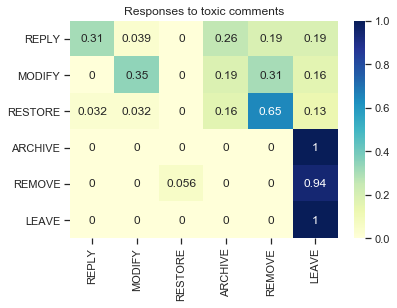

In [48]:
sns.heatmap(tr_matrix_toxic, cmap="YlGnBu", annot=True).set_title('Responses to toxic comments')

Text(0.5, 1, 'Responses to nontoxic comments')

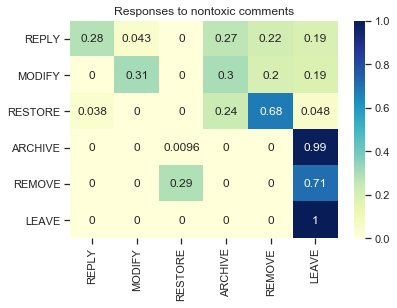

In [49]:
sns.heatmap(tr_matrix_nontoxic, cmap="YlGnBu", annot=True).set_title('Responses to nontoxic comments')

More nontoxic comments were restored after being removed, which means removal of toxic comments often are not final. Archive more often follows modify and restore for nontoxic comments. Modified toxic comments were more likely to be removed than modified nontoxic comments. 

There also exist similar patterns between the two types of comments. Their replies are equally likely to attract replies. So are their modifications. Their restorations are similarly likely to be reverted. 

Differences are derived from observations. Further statistical tests of differences are needed. 

## Stationary distributions

In [50]:
def find_stationary_dist(P, state, ax, title, legend=True):
    '''
    Create plot of stationary distribution, starting from a given state 
    and transition probability matrix. 
    '''
    
    state = np.array([state])
    stateHist=state

    for x in range(10):
        state = np.dot(state, P)
        stateHist =np.append(stateHist,state,axis=0)

    dfDistrHist = pd.DataFrame(stateHist, columns=states)
    dfDistrHist.plot(ax=ax, legend=legend, title=title)
    remove_border(ax)

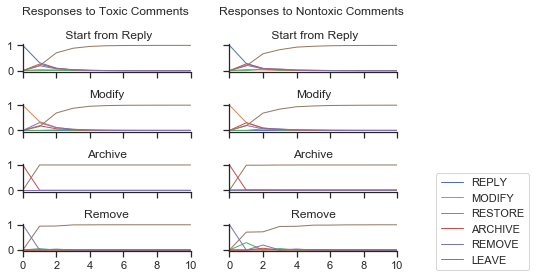

In [59]:
fig, axes = plt.subplots(4, 2, sharey=True, sharex=True)

find_stationary_dist(tr_matrix_toxic, state=[1, 0, 0, 0, 0, 0], ax=axes[0,0], 
                     title='Responses to Toxic Comments \n\n Start from Reply', legend=False)
find_stationary_dist(tr_matrix_nontoxic, state=[1, 0, 0, 0, 0, 0], ax=axes[0,1], 
                     title='Responses to Nontoxic Comments \n\n Start from Reply', legend=False)

find_stationary_dist(tr_matrix_toxic, state=[0, 1, 0, 0, 0, 0], ax=axes[1,0], title='Modify', legend=False)
find_stationary_dist(tr_matrix_nontoxic, state=[0, 1, 0, 0, 0, 0], ax=axes[1,1], title='Modify', legend=False)

find_stationary_dist(tr_matrix_toxic, state=[0, 0, 0, 1, 0, 0], ax=axes[2,0], title='Archive', legend=False)
find_stationary_dist(tr_matrix_nontoxic, state=[0, 0, 0, 1, 0, 0], ax=axes[2,1], title='Archive', legend=False)

find_stationary_dist(tr_matrix_toxic, state=[0, 0, 0, 0, 1, 0], ax=axes[3,0], title='Remove', legend=False)
find_stationary_dist(tr_matrix_nontoxic, state=[0, 0, 0, 0, 1, 0], ax=axes[3,1], title='Remove', legend=False)

fig.tight_layout(pad=1)
plt.legend(bbox_to_anchor=(1.2, 3))
# plt.savefig('../plots/stationary_dist.pdf', bbox_inches='tight')

The major visible difference is when starting from the removal action. Nontoxic comments are likely to go through restore and archive after beign removed, whereas toxic comments do not seem to have any followup action after being removed. 